# 代入所需要的库

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# 载入数据 premium.csv

In [2]:
train = pd.read_csv('./premium.csv')
print('Train data shape:',train.shape)

Train data shape: (1338, 7)


In [3]:
# 查看数据
train.info()
train.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 数据预处理

## 缺失值处理

In [4]:
# 判断数据是否有缺失值，若有缺失值需要做缺失值处理
pd.isnull(train).values.any()

False

In [5]:
# 无缺失值
train.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## 离散值处理

In [6]:
numeric_features = ['age','bmi','children','charges']
categorical_features = ['sex','smoker','region']

male      676
female    662
Name: sex, dtype: int64

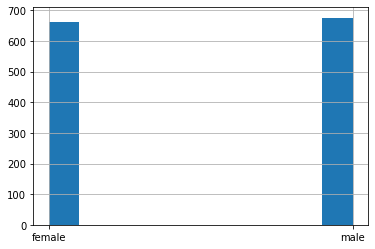

In [7]:
train['sex'].hist()
train['sex'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

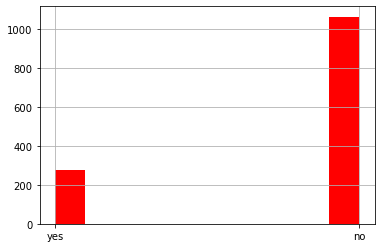

In [8]:
train['smoker'].hist(color='red')
train['smoker'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

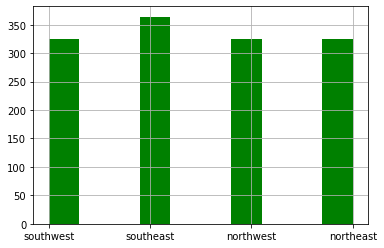

In [9]:
train['region'].hist(color='green')
train['region'].value_counts()

In [10]:
# 离散值数值化
for c in range(len(categorical_features)):
    train[categorical_features[c]] = train[categorical_features[c]].astype('category').cat.codes

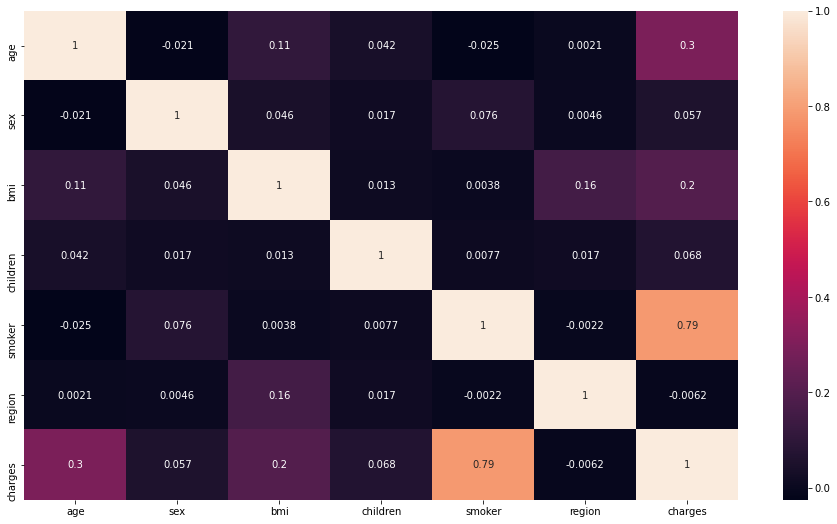

In [11]:
# 得到各个变量的相关性
plt.subplots(figsize=(16,9))
correlation_mat = train.corr()
sns.heatmap(correlation_mat , annot = True)

## 分析预测值分布

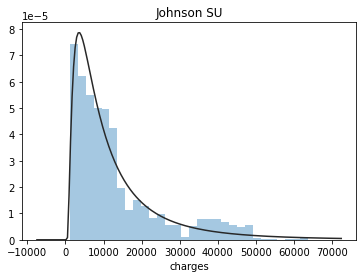

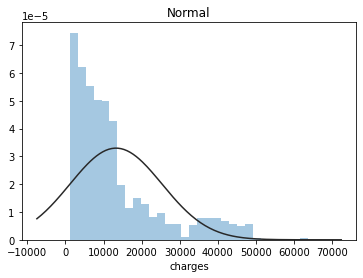

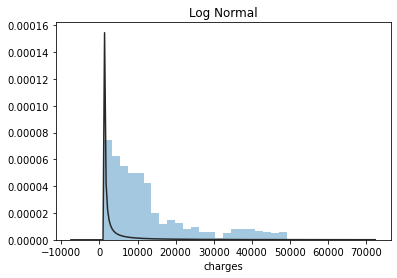

In [12]:
## 1) 总体分布概况（无界约翰逊分布等）
import scipy.stats as st
y = train['charges']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

我们的价格不服从正态分布，所以在进行回归之前，它必须进行转换。虽然对数变换做得很好，但最佳拟合是无界约翰逊分布

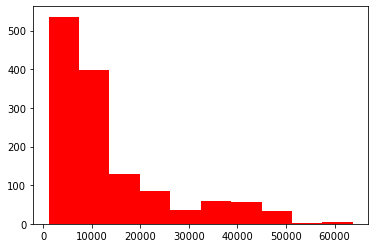

In [13]:
plt.hist(train['charges'], orientation = 'vertical',histtype = 'bar', color ='red')
plt.show()

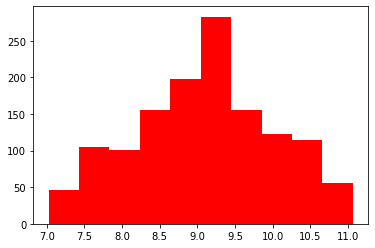

In [14]:
# log变换 z之后的分布较均匀，可以进行log变换进行预测，这也是预测问题常用的trick
plt.hist(np.log(train['charges']), orientation = 'vertical',histtype = 'bar', color ='red') 
plt.show()

# 建模调参

取20%的数据作为我们的测试集，其他都是训练集，来对我们的目标进行优化

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
X, y = train[train.columns.delete(-1)],train['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 线性回归模型 LinearRegression

In [16]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
coef = linear_model.coef_#回归系数
linear_pre = linear_model.predict(X_test)
print('SCORE:{:.4f}'.format(linear_model.score(X_test, y_test)))
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, linear_pre))))
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,linear_pre))))

SCORE:0.7999
RMSE:5643.2197
MAE:62.6924


## SVM模型

### 支持向量机 利用线性核

In [17]:
from sklearn.svm import SVR
linear_svr = SVR(kernel="linear")
linear_svr.fit(X_train, y_train)
linear_svr_pre = linear_svr.predict(X_test)#预测值

print('SCORE:{:.4f}'.format(linear_svr.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, linear_svr_pre))))#RMSE(标准误差)
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,linear_svr_pre))))

SCORE:-0.0894
RMSE:13166.3906
MAE:81.6391


### 支持向量机 多项式核

In [18]:
poly_svr = SVR(kernel="poly")
poly_svr.fit(X_train, y_train)
poly_svr_pre = poly_svr.predict(X_test)#预测值
print('SCORE:{:.4f}'.format(poly_svr.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, poly_svr_pre))))#RMSE(标准误差)
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,poly_svr_pre))))

SCORE:-0.0736
RMSE:13070.7741
MAE:89.7211


## 决策树

In [19]:
from sklearn.tree import DecisionTreeRegressor
tree_reg=DecisionTreeRegressor(max_depth=5)
tree_reg.fit(X_train, y_train)
tree_reg_pre = tree_reg.predict(X_test)#预测值
print('SCORE:{:.4f}'.format( tree_reg.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,tree_reg_pre))))#RMSE(标准误差)
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,tree_reg_pre))))

SCORE:0.8348
RMSE:5126.5151
MAE:52.8722


## 随机森林 RandomForest 

In [20]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train,y_train)
forest_pre = tree_reg.predict(X_test)#预测值
print('SCORE:{:.4f}'.format(forest.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,forest_pre))))#RMSE(标准误差)
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,forest_pre))))

SCORE:0.8705
RMSE:5126.5151
MAE:52.8722


## XGBOOST

In [21]:
from xgboost import XGBRegressor
xgb = XGBRegressor(seed=0)
xgb.fit(X_train, y_train)
xgb_pre = xgb.predict(X_test)#预测值
print('SCORE:{:.4f}'.format(xgb.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,xgb_pre))))#RMSE(标准误差)
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,xgb_pre))))

SCORE:0.8547
RMSE:4809.0776
MAE:53.9696


## 利用网格调参策略

在这一部分之中，利用网格调参进行寻找最优参数

我们将学习率的范围设为0.01 ~ 0.2

将最大深度的范围设为1~10

迭代次数设为2~30

利用这些参数进行组合，利用网格调参函数来运行，最后得出最优的参数

In [31]:
learning_rate = [0.01*i for i in range(1,21)]   #学习率
n_estimators = [i for i in range(2,30)]
max_depth = [i for i in range(1,10)]
param_grid = dict(learning_rate = learning_rate,n_estimators = n_estimators,max_depth=max_depth)#转化为字典格式

In [33]:
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(XGBRegressor(seed=0),param_grid,cv=5)
model = model.fit(X_train, y_train)
model.best_params_

{'learning_rate': 0.18, 'max_depth': 3, 'n_estimators': 28}

得到最优参数 learning_rate=0.18,max_depth=3,n_estimators=28

利用最优参数求解问题

In [56]:
model = XGBRegressor(learning_rate=0.18,max_depth=3,n_estimators=28,subsample=0.7)
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.18, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=28, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

最后在测试集中得分90.21%，MAE的误差为48.66左右

In [58]:
xgb_pre = model.predict(X_test)#预测值
print('SCORE:{:.4f}'.format(model.score(X_test, y_test)))#模型评分
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test,xgb_pre))))#RMSE(标准误差)
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,xgb_pre))))

SCORE:0.9021
RMSE:3946.1639
MAE:48.6592


In [ ]:
from torchinfo import summary
summary(net, (1, 3, 224, 224)) # 1：batch_size 3:图片的通道数 224: 图片的高宽